In [29]:
import pandas as pd
import sqlite3
from sqlite3 import Error
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime as dt
import statsmodels.api as sm

In [4]:
pd.options.display.max_columns = 150

## Вид данных

In [5]:
def create_connection(db_file):
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        print(sqlite3.version)
    except Error as e:
        print(e)
    return conn

database = r"pythonsqlite.db"
conn = create_connection(database)

2.6.0


In [6]:
query = '''
SELECT 
    PRICE_DATE, 
    d.FIGI,
    CLOSE_PRICE,
    OPEN_PRICE,
    HIGH_PRICE,
    LOW_PRICE,
    CURRENCY,
    NAME,
    TICKER,
    ISIN
FROM stocks_daily d
LEFT JOIN 
    stocks i ON i.FIGI = d.FIGI
'''
stocks_daily_df_1 = pd.read_sql(sql=query, con=conn)

In [7]:
query = ''' SELECT * FROM stocks_yahoo '''
stocks_yahoo_df_1 = pd.read_sql(sql=query, con=conn)

In [8]:
stocks_daily_df_1['PRICE_DATE'] = pd.to_datetime(stocks_daily_df_1['PRICE_DATE'])
stocks_daily_df_1['PRICE_DATE'] = stocks_daily_df_1['PRICE_DATE'].dt.date
stocks_daily_df_1.loc[:, 'WEEKDAY'] = stocks_daily_df_1.loc[:, 'PRICE_DATE'].dt.weekday
stocks_daily_df_1.loc[:, 'MONTH'] = stocks_daily_df_1.loc[:, 'PRICE_DATE'].dt.month

В данных Yahoo была особенность - тикеры (идентификаторы акций)  ценных бумаг определенных стран имели специальные суффиксы, которые немного нарушали униффицированный вид данного международного идентификатора и требовали к себе особого отношения

In [15]:
stocks_yahoo_df_1['SYMBOL'] = stocks_yahoo_df_1['SYMBOL'].str.replace('\.ME', '')
stocks_yahoo_df_1['SYMBOL'] = stocks_yahoo_df_1['SYMBOL'].str.replace('\.DE', '@DE')

<ipython-input-15-84bf872b9c9a>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  stocks_yahoo_df_1['SYMBOL'] = stocks_yahoo_df_1['SYMBOL'].str.replace('\.ME', '')
<ipython-input-15-84bf872b9c9a>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  stocks_yahoo_df_1['SYMBOL'] = stocks_yahoo_df_1['SYMBOL'].str.replace('\.DE', '@DE')


Также тикер мог дублироваться для разных рынков, которые однако не рассматриваются в брокере Тинькофф

In [16]:
stocks_daily_df_2 = stocks_daily_df_1.merge(
    stocks_yahoo_df_1, how="inner", left_on="TICKER", right_on="SYMBOL"
)

stocks_daily_df_2 = stocks_daily_df_2[
    ~(
        (stocks_daily_df_2["MARKET"] == "us_market")
        & (stocks_daily_df_2["CURRENCY"] == "RUB")
    )
].reset_index(drop = True)

In [17]:
stocks_daily_df_2.sample(4)

,PRICE_DATE,FIGI,CLOSE_PRICE,OPEN_PRICE,HIGH_PRICE,LOW_PRICE,CURRENCY,NAME,TICKER,ISIN,WEEKDAY,MONTH,SYMBOL,SECTOR,INDUSTRY,MARKET,COUNTRY,LONG_BUSINESS_SUMMARY,CITY,FULL_TIME_EMPLOYEES,TRAILING_ANNUAL_DIVIDEND_YIELD,PAYOUT_RATIO,BETA,PRICE_HINT,FORWARD_PE,ENTERPRISE_TO_EBITDA,FORWARD_EPS,BOOK_VALUE,NET_INCOME_TO_COMMON,ENTERPRISE_TO_REVENUE,PROFIT_MARGINS,PRICE_TO_BOOK
155452,2020-12-18,BBG000C4GBR6,39.360,37.990,39.610,37.970,USD,NETGEAR Inc,NTGR,US64111Q1040,4,12,NTGR,Technology,Communication Equipment,us_market,United States,"NETGEAR, Inc. designs, develops, and markets n...",San Jose,775.0,NaN,0.0000,0.622173,2.0,11.336283,6.099,3.39,23.552,85426000.0,0.576,0.06360,1.631709
165648,2021-01-13,BBG000CJ2181,132.120,135.240,135.240,130.790,USD,Reliance Steel & Aluminum Co,RS,US7595091023,2,1,RS,Basic Materials,Steel,us_market,United States,Reliance Steel & Aluminum Co. operates as a me...,Los Angeles,12800.0,0.016557,0.2892,1.064705,2.0,13.902931,11.127,10.92,83.865,574300032.0,1.307,0.06327,1.810291
297404,2020-07-29,BBG003BNWBP3,1.597,1.577,1.667,1.572,RUB,ЧЗПСН,PRFN,RU000A0JNXF9,2,7,PRFN,Industrials,Engineering & Construction,ru_market,Russia,Public joint stock company 'Chelyabinsk plant ...,Chelyabinsk,NaN,NaN,0.0000,1.726359,4.0,NaN,10.073,NaN,12.784,22336000.0,0.562,0.00437,0.127034
119056,2021-04-29,BBG000BT7JW9,240.030,239.280,240.520,237.500,USD,Snap-on,SNA,US8330341012,3,4,SNA,Industrials,Tools & Accessories,us_market,United States,Snap-on Incorporated manufactures and markets ...,Kenosha,12300.0,0.021475,0.3711,1.303916,2.0,15.217793,12.914,14.05,71.717,682400000.0,3.345,0.16574,2.981301


Сдвиги праздничных дней вещь аномальная, поэтому данные по бумагам за субботу исключены из расчетов

In [18]:
stocks_daily_df_3 = stocks_daily_df_2[stocks_daily_df_2["WEEKDAY"] != 5].reset_index(
    drop=True
)


Как выглядят данные на примере нескольких бумаг

In [19]:
choosen_tickers = ["OZON", "SBER", "YNDX"]
prices_columns = ["CLOSE_PRICE", "OPEN_PRICE", "HIGH_PRICE", "LOW_PRICE"]
colors_1 = ["royalblue", "darkgreen", "red"]
colors_2 = ["dodgerblue", "limegreen", "indianred"]
df_1 = stocks_daily_df_3[stocks_daily_df_3["TICKER"].isin(choosen_tickers)].reset_index(
    drop=True
)


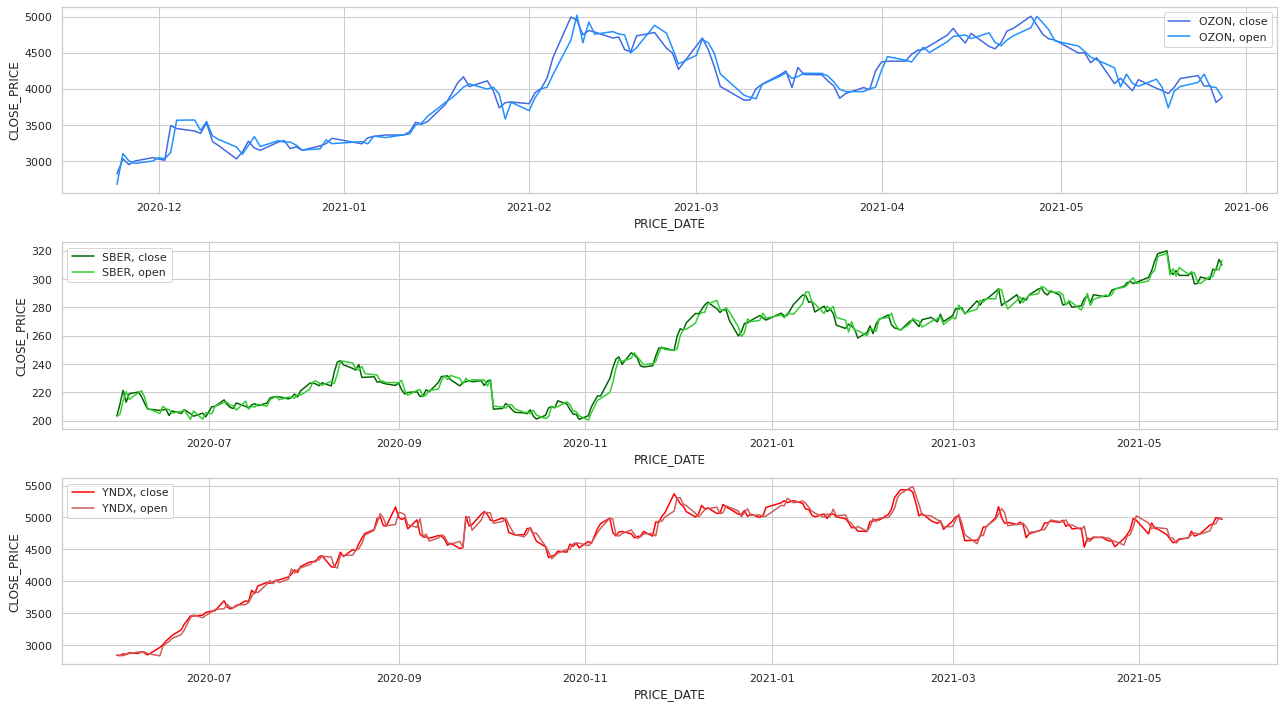

In [20]:
with sns.plotting_context("notebook"), sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(3, 1, figsize=(18, 10))
    for i, ticker in enumerate(choosen_tickers):
        sns.lineplot(
            ax=axes[i],
            data=df_1[df_1["TICKER"] == ticker],
            x="PRICE_DATE",
            y="CLOSE_PRICE",
            label=ticker+', close',
            color=colors_1[i],
        )
        sns.lineplot(
            ax=axes[i],
            data=df_1[df_1["TICKER"] == ticker],
            x="PRICE_DATE",
            y="OPEN_PRICE",
            label=ticker+', open',
            color=colors_2[i],
        )
    plt.tight_layout()


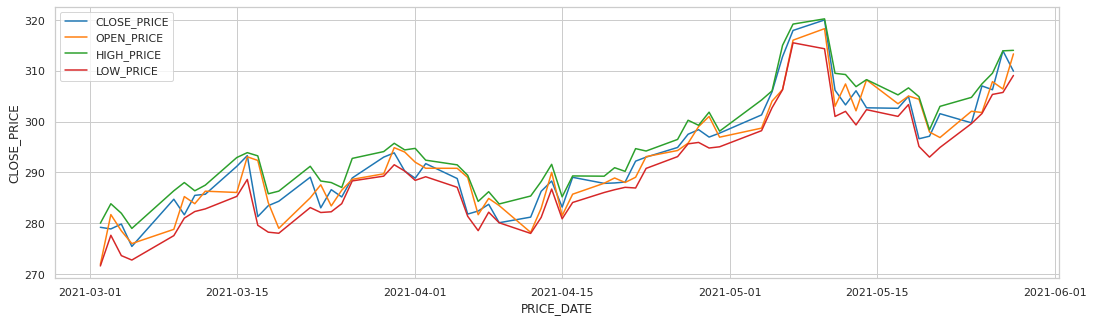

In [41]:
with sns.plotting_context("notebook"), sns.axes_style("whitegrid"):
    plt.rcParams['figure.figsize'] = (18,5)
    for i, price_type in enumerate(prices_columns):
        sns.lineplot(
            data=df_1[(df_1["PRICE_DATE"] > dt.strptime('20210301' , '%Y%m%d').date())&(df_1["TICKER"] == 'SBER')],
            x="PRICE_DATE",
            y=price_type,
            label=price_type,
        )


###  Подитог
На каждый момент времени помимо справочных данных известны данные о том как выглядили продажи бумаг за текущий и прошлые периоды. 
Интересом может являться то, как будет себя вести бумага в следующем периоде. 

Каждая ценная бумага имеет свою цену, при этом их масштаб мало что говорит о них. Больше о бумагах говорит динамика поведения стоимости от последней известной (на закрытии периода).

In [35]:
for field in prices_columns:
    df_1["CHANGE_" + field] = (
        df_1[field] / df_1.groupby("TICKER")["CLOSE_PRICE"].shift()
    )
    stocks_daily_df_3["CHANGE_" + field] = (
        stocks_daily_df_3[field]
        / stocks_daily_df_3.groupby("TICKER")["CLOSE_PRICE"].shift()
    )


In [38]:
df_1[
    [
        "CLOSE_PRICE",
        "OPEN_PRICE",
        "HIGH_PRICE",
        "LOW_PRICE",
        "CHANGE_CLOSE_PRICE",
        "CHANGE_OPEN_PRICE",
        "CHANGE_HIGH_PRICE",
        "CHANGE_LOW_PRICE",
    ]
].head(5)


,CLOSE_PRICE,OPEN_PRICE,HIGH_PRICE,LOW_PRICE,CHANGE_CLOSE_PRICE,CHANGE_OPEN_PRICE,CHANGE_HIGH_PRICE,CHANGE_LOW_PRICE
0,203.66,203.10,205.93,201.81,NaN,NaN,NaN,NaN
1,212.00,204.67,212.00,204.00,1.040951,1.004959,1.040951,1.001669
2,221.50,214.00,221.92,213.51,1.044811,1.009434,1.046792,1.007123
3,213.10,220.67,221.00,212.55,0.962077,0.996253,0.997743,0.959594
4,219.10,215.13,219.93,213.60,1.028156,1.009526,1.032051,1.002346


Логично предположить, что поведение бумаги зависит от самой бумаги - от ее известности или сферы. Также возможна зависимость от времени совершения сделки.

In [39]:
df_1.groupby(["TICKER", "WEEKDAY"])[
    ["CHANGE_CLOSE_PRICE", "CHANGE_OPEN_PRICE", "CHANGE_HIGH_PRICE", "CHANGE_LOW_PRICE"]
].agg(["median", "count"])


CHANGE_CLOSE_PRICE       CHANGE_OPEN_PRICE        \
                           median count            median count   
TICKER WEEKDAY                                                    
OZON   0                 1.009670    24          1.002831    24   
       1                 1.002974    25          1.002341    25   
       2                 1.000910    27          1.003691    27   
       3                 0.992413    25          1.003592    25   
       4                 1.006456    26          1.005867    26   
SBER   0                 1.005477    49          1.002838    49   
       1                 1.003960    51          1.003841    51   
       2                 1.001059    49          1.001307    49   
       3                 0.999451    50          1.001532    50   
       4                 0.999931    50          1.000467    50   
YNDX   0                 1.008812    49          1.004588    49   
       1                 1.001106    51          1.000359    51   
       2                 1.001036    49          1.001539    49   
       3                 1.000183    50          1.000223    50   
       4                 1.001740    50          1.001732    50   

               CHANGE_HIGH_PRICE       CHANGE_LOW_PRICE        
                          median count           median count  
TICKER WEEKDAY                                                 
OZON   0                1.034703    24         0.988455    24  
       1                1.025875    25         0.974923    25  
       2                1.026786    27         0.975177    27  
       3                1.028687    25         0.972005    25  
       4                1.033433    26         0.979625    26  
SBER   0                1.014841    49         0.993533    49  
       1                1.013200    51         0.993426    51  
       2                1.011520    49         0.992663    49  
       3                1.010919    50         0.988699    50  
       4                1.006898    50         0.989826    50  
YNDX   0                1.015768    49         0.991506    49  
       1                1.013935    51         0.986300    51  
       2                1.014717    49         0.987612    49  
       3                1.012744    50         0.986807    50  
       4                1.011179    50         0.989598    50

In [43]:
stocks_daily_df_3[stocks_daily_df_3["PRICE_DATE"] > dt.strptime('20210301' , '%Y%m%d').date()].groupby(
    ["SECTOR", "WEEKDAY"]
)[
    ["CHANGE_CLOSE_PRICE", "CHANGE_OPEN_PRICE", "CHANGE_HIGH_PRICE", "CHANGE_LOW_PRICE"]
].agg(
    ["median", 'count']
)


CHANGE_CLOSE_PRICE       CHANGE_OPEN_PRICE  \
                                           median count            median   
SECTOR                 WEEKDAY                                              
Basic Materials        0                 1.001911  1022          1.001402   
                       1                 0.996648  1179          1.000793   
                       2                 1.001548  1178          1.000910   
                       3                 1.002245  1178          1.001402   
                       4                 1.004321  1117          1.001646   
Communication Services 0                 0.999382  1067          1.001657   
                       1                 0.997467  1182          1.000926   
                       2                 0.998138  1182          1.000779   
                       3                 1.003457  1182          1.002349   
                       4                 1.001451  1101          1.001369   
Consumer Cyclical      0                 1.001452  2547          1.000761   
                       1                 0.994653  2794          1.000393   
                       2                 0.999265  2794          1.000756   
                       3                 1.003002  2795          1.001794   
                       4                 1.007235  2587          1.001847   
Consumer Defensive     0                 1.002066  1119          1.001187   
                       1                 0.996593  1237          1.001073   
                       2                 0.998846  1237          1.000857   
                       3                 1.002485  1238          1.001493   
                       4                 1.003558  1154          1.001554   
Energy                 0                 0.999432   762          1.002317   
                       1                 0.990976   858          1.001193   
                       2                 1.007571   858          1.001826   
                       3                 0.998620   858          1.001655   
                       4                 1.004444   807          1.002286   
Financial Services     0                 1.000661  1762          1.000195   
                       1                 0.993447  1937          1.000120   
                       2                 1.003132  1937          1.001003   
                       3                 1.005268  1937          1.000873   
                       4                 1.007804  1797          1.002302   
Healthcare             0                 0.998511  2858          1.000388   
                       1                 0.996796  3119          1.000535   
                       2                 0.999191  3119          1.000371   
                       3                 1.003164  3120          1.001137   
                       4                 1.003956  2884          1.001321   
Industrials            0                 1.001228  2668          1.000707   
                       1                 0.993983  2938          1.000000   
                       2                 1.000399  2938          1.000669   
                       3                 1.004334  2939          1.001604   
                       4                 1.006722  2730          1.001695   
Real Estate            0                 1.003136   730          1.000141   
                       1                 0.999666   806          1.000553   
                       2                 0.997705   806          1.000196   
                       3                 1.004450   806          1.001098   
                       4                 1.005722   749          1.002041   
Technology             0                 0.999322  2869          1.000564   
                       1                 0.995679  3114          1.000389   
                       2                 0.997646  3113          1.000906   
                       3                 1.005274  3115          1.002482   
                       4   

Стоит обратить внимание, что бумаги которые за исследуемый годовой период только вышли на биржу и пока имеют более волатильное поведение, могут смазать картину по рынку в среднем. На данном этапе такие бумаги игнорируются

In [45]:
val_counts_1 = stocks_daily_df_3['TICKER'].value_counts()
stocks_daily_df_4 = stocks_daily_df_3[stocks_daily_df_3['TICKER'].isin(val_counts_1[val_counts_1>100].index)].reset_index()

Если говорить о глабольном поведении цен, то данные за последний год показывают больше роста, чем падаений. 

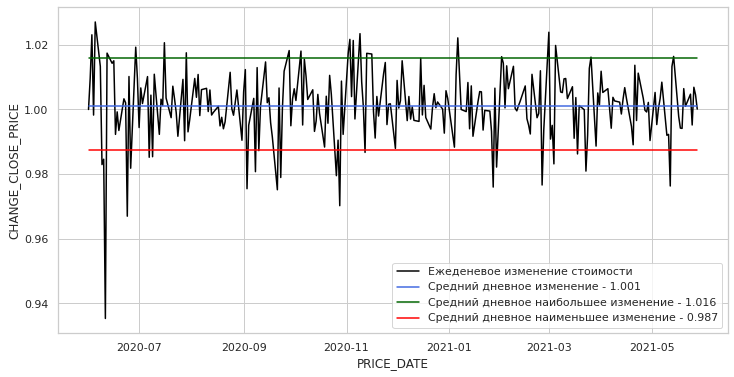

In [57]:
with sns.plotting_context("notebook"), sns.axes_style("whitegrid"):
    fig = plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=stocks_daily_df_4.groupby("PRICE_DATE")["CHANGE_CLOSE_PRICE"]
        .median()
        .reset_index(),
        x="PRICE_DATE",
        y="CHANGE_CLOSE_PRICE",
        label="Ежеденевое изменение стоимости",
        color="k",
    )
    market_change_mean = [
        stocks_daily_df_4.groupby("PRICE_DATE")["CHANGE_CLOSE_PRICE"].median().mean(),
        stocks_daily_df_4.groupby("PRICE_DATE")["CHANGE_HIGH_PRICE"].median().mean(),
        stocks_daily_df_4.groupby("PRICE_DATE")["CHANGE_LOW_PRICE"].median().mean(),
    ]
    labels = [
        "Средний дневное изменение",
        "Средний дневное наибольшее изменение",
        "Средний дневное наименьшее изменение",
    ]
    for i in range(3):
        sns.lineplot(
            x=stocks_daily_df_4.groupby("PRICE_DATE")["CHANGE_CLOSE_PRICE"]
            .mean()
            .index,
            y=market_change_mean[i],
            label=labels[i] + ' - {:.3f}'.format(market_change_mean[i]),
            color=colors_1[i],
        )


Хотя 0.1 % небольшое значение, тот факт что это среднее ежедневное значение медианы, говорит о !возможном! значительном росте за год

In [60]:
print(1.001**365)

1.4402513134295205


### Данные как временной ряд

<ipython-input-110-6ae5bfc05826>:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  result = seasonal_decompose(df_1[df_1['TICKER']=='OZON']['CLOSE_PRICE'], model='additive', freq = 5)


<Figure size 432x288 with 0 Axes>

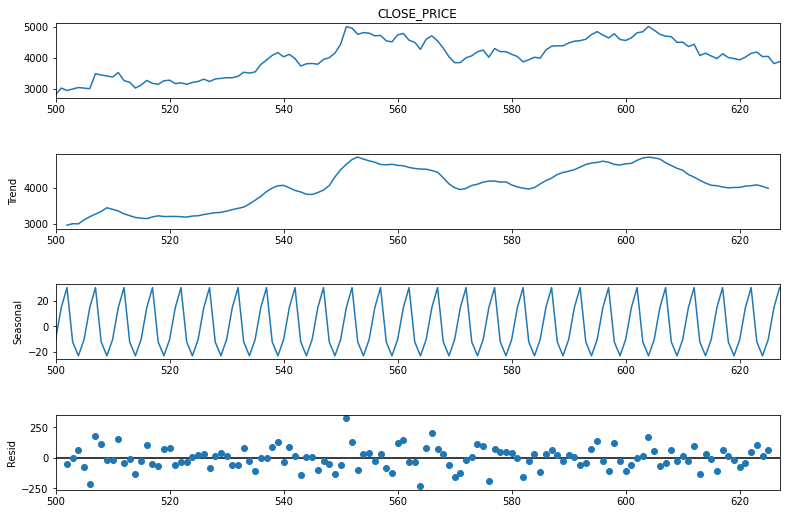

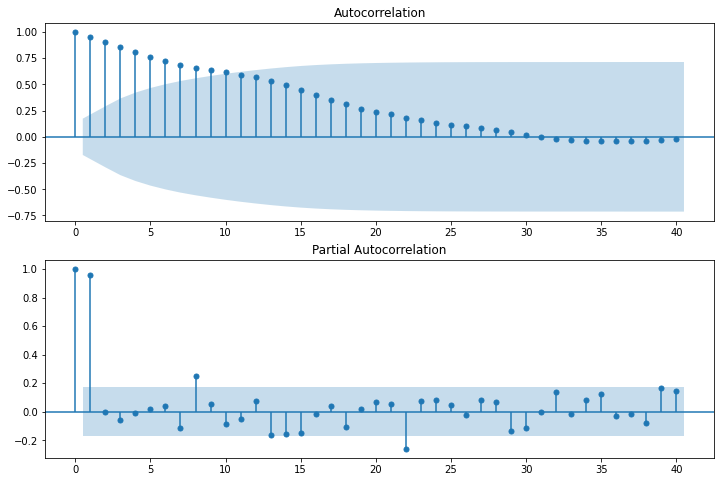

In [110]:
result = seasonal_decompose(
    df_1[df_1["TICKER"] == "OZON"]["CLOSE_PRICE"], model="additive", freq=5
)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(12, 8)

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(
    df_1[df_1["TICKER"] == "OZON"]["CLOSE_PRICE"], lags=40, ax=ax1
)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(
    df_1[df_1["TICKER"] == "OZON"]["CLOSE_PRICE"], lags=40, ax=ax2
)


<ipython-input-111-ce4cc552fd87>:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  result = seasonal_decompose(df_1[df_1['TICKER']=='SBER']['CLOSE_PRICE'], model='additive', freq = 5)


<Figure size 432x288 with 0 Axes>

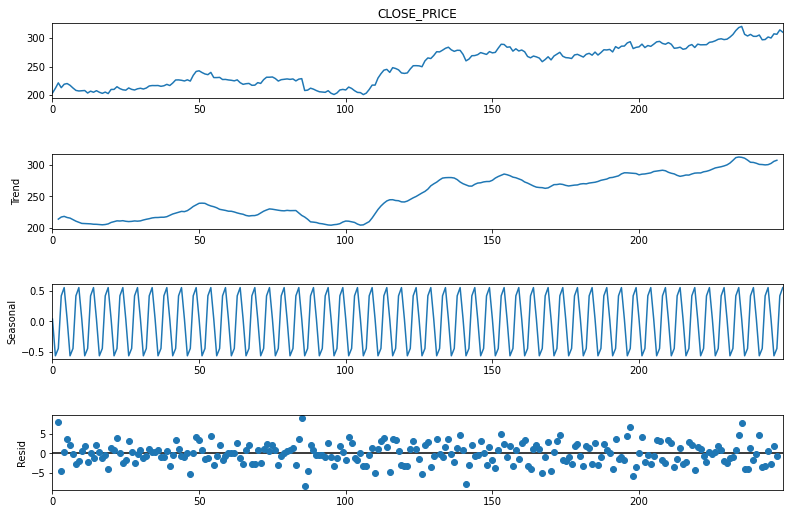

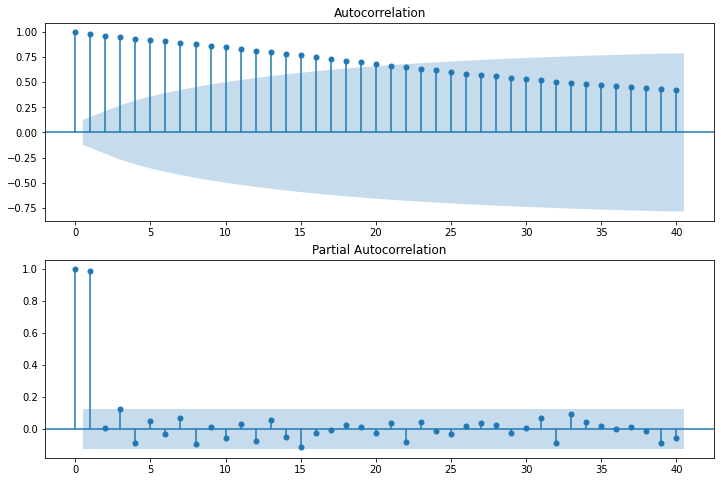

In [111]:
result = seasonal_decompose(df_1[df_1['TICKER']=='SBER']['CLOSE_PRICE'], model='additive', freq = 5)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(12,8)

fig = plt.figure(figsize = (12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_1[df_1['TICKER']=='SBER']['CLOSE_PRICE'], lags = 40, ax =ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_1[df_1['TICKER']=='SBER']['CLOSE_PRICE'], lags = 40, ax = ax2)

<ipython-input-112-f563b03e7638>:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  result = seasonal_decompose(df_1[df_1['TICKER']=='YNDX']['CLOSE_PRICE'], model='additive', freq = 5)


<Figure size 432x288 with 0 Axes>

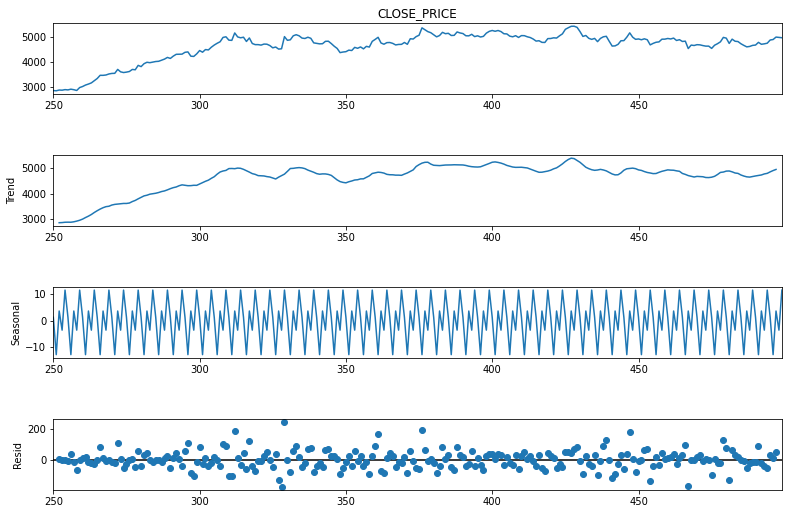

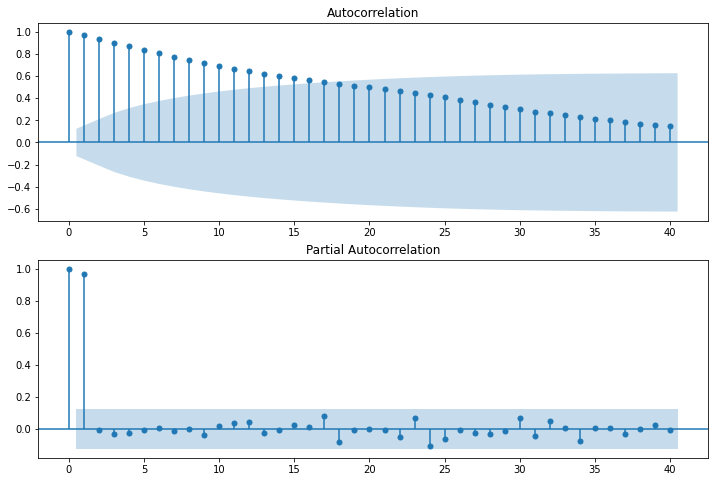

In [112]:
result = seasonal_decompose(df_1[df_1['TICKER']=='YNDX']['CLOSE_PRICE'], model='additive', freq = 5)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(12,8)

fig = plt.figure(figsize = (12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_1[df_1['TICKER']=='YNDX']['CLOSE_PRICE'], lags = 40, ax =ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_1[df_1['TICKER']=='YNDX']['CLOSE_PRICE'], lags = 40, ax = ax2)

Попытка работать с данными как с временными рядами не показывает значимых результатов. Так как цены бумаг за дневной период могут сильно поменяться от множества факкторов не связанных с глобальной историей цены, то ожидать значимого влияния прошлых цен на текущую кажется не самым надежным вариантом.

Подобный вывод подтверждается и рассмотренными выше бумагами - тренд нестабилен и менятся от не связанных от времени условий, влияние какого либо лага кроме прошлого из частичной автокорреляции не наблюдается.

## Итог
Рассмотренные этапы препроцессинга будут использоваться для задачи моделирования. 
Моделирование будет ставить целью прогноз роста каждой бумаги на день вперед, на основе известных в моменте данных  о прошлой динамике, и справочной информации